**Importing libraries**

In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

**Converting gold chat .txt data to pandas**

In [2]:
filename = "./example-data/gold_1h.txt"
pd.set_option('display.max_columns', None)
df = pd.read_csv(filename, delimiter="\t")
# Open the text file and read its contents line by line
txtData = []
with open(filename, 'r') as file:
    for line in file:
        values = line.split('\t')
        txtData.append(values)
columnNames = txtData[0][0].split()
txtData = txtData[1:]
txtDataTransform = []
# Initialize an empty DataFrame
df = pd.DataFrame(columns=columnNames)

# Append data to the DataFrame
for sublist in txtData:
    row = sublist[0].split()[1:]
    joinedDateStr = ' '.join(row[:3])
    row = [joinedDateStr] + row[3:]
    txtDataTransform.append(row)

df = pd.DataFrame(txtDataTransform, columns=columnNames)
print(df.head())

                           date     open     high      low    close volume  \
0  20230731 18:00:00 US/Eastern  1964.98  1966.09  1964.62  1965.60     -1   
1  20230731 19:00:00 US/Eastern  1965.60  1965.74  1963.82  1963.92     -1   
2  20230731 20:00:00 US/Eastern  1963.92  1964.68  1962.97  1963.40     -1   
3  20230731 21:00:00 US/Eastern  1963.40  1963.94  1960.67  1960.94     -1   
4  20230731 22:00:00 US/Eastern  1960.94  1961.05  1958.97  1960.57     -1   

   rsi stoch_k stoch_d  
0  NaN     NaN     NaN  
1  NaN     NaN     NaN  
2  NaN     NaN     NaN  
3  NaN     NaN     NaN  
4  NaN     NaN     NaN  


**Model training**

In [3]:
# Choose the column you want to predict (e.g., 'Close' price)
target_column = 'close'
targetedSeries = df[[target_column]]

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(targetedSeries)

# Create sequences for training
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 200  # You can adjust this sequence length
X, y = create_sequences(data_scaled, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=70, batch_size=32, verbose=1)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Training Loss: {train_loss:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the scaled predictions
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

# You can now analyze and visualize the predictions and actual prices

Epoch 1/70
12/12 [==============================] - 3s 86ms/step - loss: 0.1677
Epoch 2/70
12/12 [==============================] - 1s 85ms/step - loss: 0.0362
Epoch 3/70
12/12 [==============================] - 1s 84ms/step - loss: 0.0117
Epoch 4/70
12/12 [==============================] - 1s 86ms/step - loss: 0.0088
Epoch 5/70
12/12 [==============================] - 1s 84ms/step - loss: 0.0058
Epoch 6/70
12/12 [==============================] - 1s 85ms/step - loss: 0.0044
Epoch 7/70
12/12 [==============================] - 1s 85ms/step - loss: 0.0035
Epoch 8/70
12/12 [==============================] - 1s 82ms/step - loss: 0.0031
Epoch 9/70
12/12 [==============================] - 1s 84ms/step - loss: 0.0029
Epoch 10/70
12/12 [==============================] - 1s 85ms/step - loss: 0.0027
Epoch 11/70
12/12 [==============================] - 1s 81ms/step - loss: 0.0026
Epoch 12/70
12/12 [==============================] - 1s 85ms/step - loss: 0.0025
Epoch 13/70
12/12 [==================

**Predicting next sequence price**

In [38]:
# Predict the next date sequence
last_sequence = data_scaled[-sequence_length:].reshape(1, sequence_length, 1)
next_sequence = model.predict(last_sequence)

# Inverse transform the scaled prediction for the next date
next_sequence_original = scaler.inverse_transform(next_sequence)

1/1 [==============================] - 0s 43ms/step


**Plot trained and evaluated data**

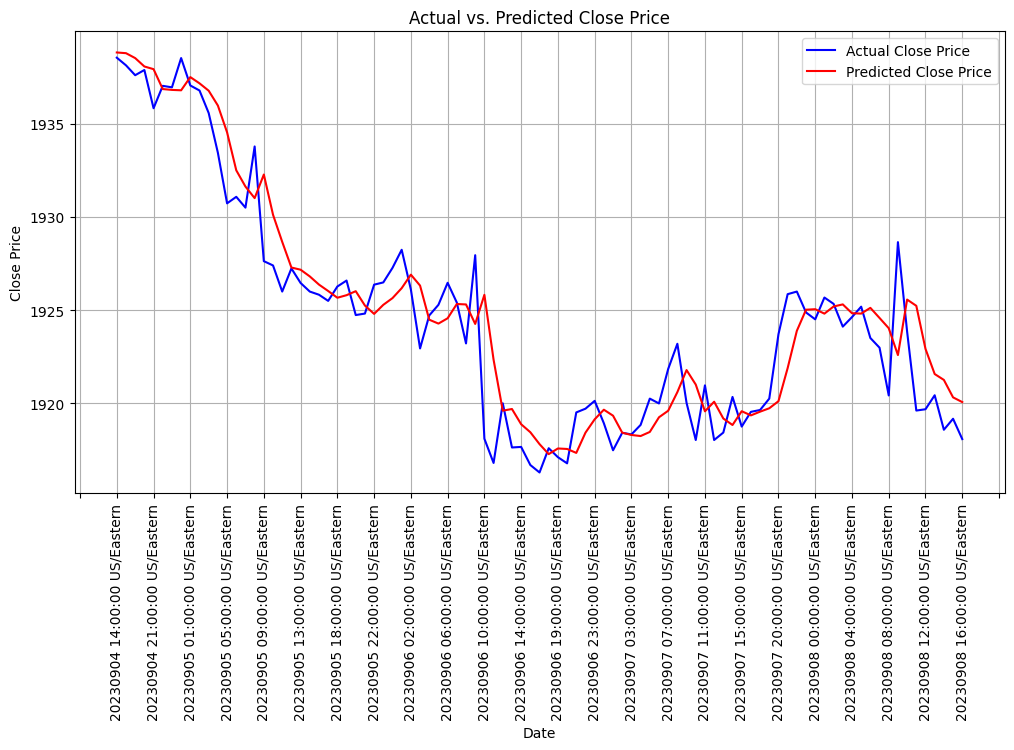

572    20230904 14:00:00 US/Eastern
573    20230904 18:00:00 US/Eastern
574    20230904 19:00:00 US/Eastern
575    20230904 20:00:00 US/Eastern
576    20230904 21:00:00 US/Eastern
                   ...             
660    20230908 12:00:00 US/Eastern
661    20230908 13:00:00 US/Eastern
662    20230908 14:00:00 US/Eastern
663    20230908 15:00:00 US/Eastern
664    20230908 16:00:00 US/Eastern
Name: date, Length: 93, dtype: object


In [39]:
# Assuming your DataFrame has a column named 'Date' for the x-axis
# Plot the actual and predicted values
date = df["date"][-len(y_test_original):]
plt.figure(figsize=(12, 6))
plt.plot(date, y_test_original, label='Actual Close Price', color='blue')
plt.plot(date, y_pred_original, label='Predicted Close Price', color='red')
plt.title('Actual vs. Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=30, prune='both'))
plt.show()

**Plot evaluated data with the next sequence**

['20230904 14:00:00 US/Eastern', '20230904 18:00:00 US/Eastern', '20230904 19:00:00 US/Eastern', '20230904 20:00:00 US/Eastern', '20230904 21:00:00 US/Eastern', '20230904 22:00:00 US/Eastern', '20230904 23:00:00 US/Eastern', '20230905 00:00:00 US/Eastern', '20230905 01:00:00 US/Eastern', '20230905 02:00:00 US/Eastern', '20230905 03:00:00 US/Eastern', '20230905 04:00:00 US/Eastern', '20230905 05:00:00 US/Eastern', '20230905 06:00:00 US/Eastern', '20230905 07:00:00 US/Eastern', '20230905 08:00:00 US/Eastern', '20230905 09:00:00 US/Eastern', '20230905 10:00:00 US/Eastern', '20230905 11:00:00 US/Eastern', '20230905 12:00:00 US/Eastern', '20230905 13:00:00 US/Eastern', '20230905 14:00:00 US/Eastern', '20230905 15:00:00 US/Eastern', '20230905 16:00:00 US/Eastern', '20230905 18:00:00 US/Eastern', '20230905 19:00:00 US/Eastern', '20230905 20:00:00 US/Eastern', '20230905 21:00:00 US/Eastern', '20230905 22:00:00 US/Eastern', '20230905 23:00:00 US/Eastern', '20230906 00:00:00 US/Eastern', '202309

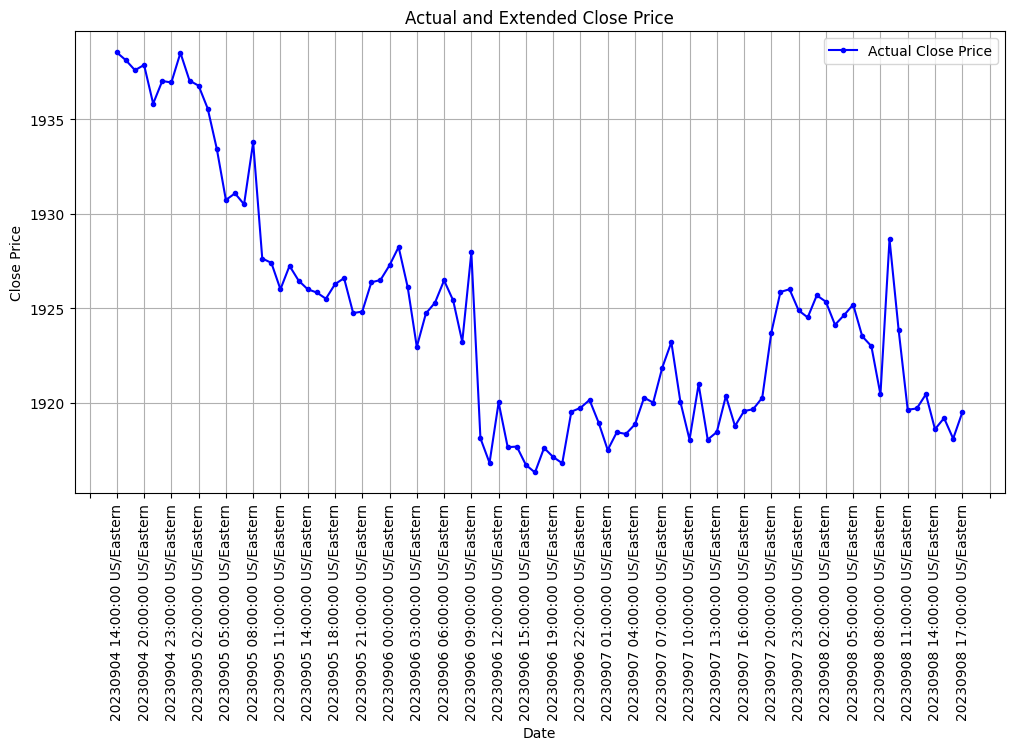

In [40]:

# Extend the sequence with the predicted value
extended_sequence = np.append(y_test_original, next_sequence_original[0][0])

# Extend the date index for the x-axis

currentDate = dt.datetime.strptime(date.iloc[-1], "%Y%m%d %H:%M:%S US/Eastern")
extendedDate = []
dateList = date.tolist()
print(dateList)
for i in range(1):
    currentDate += dt.timedelta(hours=1)
    formatedDate = currentDate.strftime("%Y%m%d %H:%M:%S US/Eastern")
    extendedDate.append(formatedDate)
dateList.extend(extendedDate)
dateList = pd.Series(dateList)
dateList.to_csv('extended_dates.csv', index=True, header=['Date'])

# Plot the actual and extended sequences
plt.figure(figsize=(12, 6))
plt.plot(dateList, extended_sequence, label='Actual Close Price', color='blue', marker='o', markersize=3)
plt.title('Actual and Extended Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=40))
plt.show()